numpy的svd实现压缩时间： 0.18988895416259766
自己实现的svd压缩时间： 0.5538010597229004


/var/folders/zs/x95qdbgs18x7yhbt32vz8ycm0000gn/T/ipykernel_5905/4180220239.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_image = compressed_image.astype('uint8')


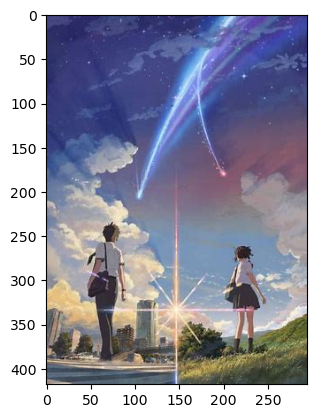

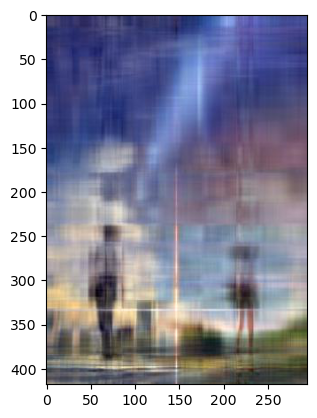

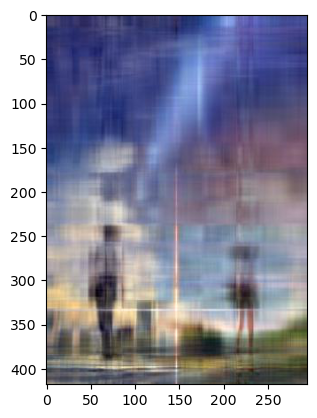

比较两种压缩方法的结果是否相同： True


In [1]:
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


class ImageCompressor:
    def __init__(self, image_path, k):
        self.image_path = image_path
        self.k = k  

    def load_image(self):
        img = Image.open(self.image_path)
        self.image_array = np.array(img)
        self.shape = self.image_array.shape

    def compress_image(self):

        reshaped_image = self.image_array.reshape(self.shape[0], -1)
        U, S, Vt = np.linalg.svd(reshaped_image, full_matrices=False)

        # 选取前k个奇异值和特征来重构图片，并恢复成与原图片相同大小
        U_k, S_k, Vt_k = U[:, :self.k], np.diag(S[:self.k]), Vt[:self.k, :]
        
        # 重构图片
        compressed_image = (U_k @ S_k) @ Vt_k
        compressed_image = compressed_image.reshape(self.shape)
        
        # 将图片的像素值限制在0-255之间
        compressed_image = np.clip(compressed_image, 0, 255)
        compressed_image = compressed_image.astype('uint8')

        return compressed_image
    
    def svd(self, X, full_matrices=False):

        # 将X的数据类型转换为float型
        X = X.astype(float)     
        
        #计算X的特征值和特征向量
        eigenvalues, V = np.linalg.eig(X.T @ X)

        # 对特征值进行排序，从大到小
        sorted_index = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_index]
        V = V[:, sorted_index]

        # 计算奇异值和左右奇异向量
        singular_values = np.sqrt(eigenvalues)
        min_dim = min(X.shape)
        singular_values = singular_values[:min_dim]

        # 计算左奇异向量，分两种情况
        if full_matrices:
            # full_matrices=True时，U的大小为m×m
            sigma = np.zeros(X.shape)
            np.fill_diagonal(sigma, singular_values)
            U = np.dot(X, np.dot(V, np.linalg.pinv(sigma)))
            return U, singular_values, V.T
        else:
            # full_matrices=False时，U的大小为m×min(m,n)
            sigma = np.diag(singular_values[:min_dim])
            U = np.dot(X, np.dot(V[:, :min_dim], np.linalg.pinv(sigma)))
            return U, singular_values, V[:, :min_dim].T

    def compress_image_yourself(self):
        reshaped_image = self.image_array.reshape(self.shape[0], -1)
        U, S, Vt = self.svd(reshaped_image, full_matrices=False)

        # 选取前k个奇异值和特征来重构图片，并恢复成与原图片相同大小
        U_k, S_k, Vt_k = U[:, :self.k], np.diag(S[:self.k]), Vt[:self.k, :]
        
        # 重构图片
        compressed_image = (U_k @ S_k) @ Vt_k
        compressed_image = compressed_image.reshape(self.shape)
        
        # 将图片的像素值限制在0-255之间
        compressed_image = np.clip(compressed_image, 0, 255)
        compressed_image = compressed_image.astype('uint8')

        return compressed_image

    def save_compressed_image(self, output_path, your_self=False):
        if your_self:
            compressed_image = self.compress_image_yourself()
        else:
            compressed_image = self.compress_image()

        compressed_image = Image.fromarray(compressed_image)
        compressed_image.save(output_path)

        

if __name__ == "__main__":
    # Example usage
    image_path = "input.jpg"
    np_output_path = "np_output.jpg"
    self_output_path = "self_output.jpg"

    k_value = 10  #选取的奇异值数量

    compressor = ImageCompressor(image_path, k_value)
    compressor.load_image()
    
    start = time.time()
    compressor.save_compressed_image(np_output_path)
    print("numpy的svd实现压缩时间：", time.time() - start)
    
    start = time.time()
    compressor.save_compressed_image(self_output_path, your_self=True)
    print("自己实现的svd压缩时间：", time.time() - start)
    
    origin_image = plt.imread(image_path)
    plt.imshow(origin_image)
    plt.show()
    
    np_compressed_image = plt.imread(np_output_path)
    plt.imshow(np_compressed_image)
    plt.show()
    
    self_compressed_image = plt.imread(self_output_path)
    plt.imshow(self_compressed_image)
    plt.show()
    
    print("比较两种压缩方法的结果是否相同：", np.allclose(np_compressed_image, self_compressed_image))


In [2]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def SSIM(original, compressed):
    u_x, sigma_x = np.mean(original), np.std(original)
    u_y, sigma_y = np.mean(compressed), np.std(compressed)
    sigma_xy = np.mean((original - u_x) * (compressed - u_y))
    C1, C2 = 0.01 ** 2, 0.03 ** 2
    return (2 * u_x * u_y + C1) * (2 * sigma_xy + C2) / ((u_x ** 2 + u_y ** 2 + C1) * (sigma_x ** 2 + sigma_y ** 2 + C2))

In [3]:
# 探究不同k下面的压缩效果
# 这里选取k=10, 50, 100, 200, 300, 400

ks = [10, 50, 100, 200, 300, 400]

for k in ks:
    image_path = "input.jpg"
    np_output_path = f"np_output_k{k}.jpg"
    self_output_path = f"self_output_k{k}.jpg"
    
    compressor = ImageCompressor(image_path, k)
    compressor.load_image()

    compressor.save_compressed_image(np_output_path)
    compressor.save_compressed_image(self_output_path, your_self=True)
    
    np_compressed_image = plt.imread(np_output_path)
    self_compressed_image = plt.imread(self_output_path)
    
    print(f"比较两种压缩方法的结果是否相同：{np.allclose(np_compressed_image, self_compressed_image)}")
    
    print(f"在k={k}时，压缩的PSNR值为：{PSNR(compressor.image_array, np_compressed_image):.5f}，SSIM值为：{SSIM(compressor.image_array, np_compressed_image):.5f}")
    

/var/folders/zs/x95qdbgs18x7yhbt32vz8ycm0000gn/T/ipykernel_5905/4180220239.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_image = compressed_image.astype('uint8')


比较两种压缩方法的结果是否相同：True
在k=10时，压缩的PSNR值为：29.58990，SSIM值为：0.92605
比较两种压缩方法的结果是否相同：True
在k=50时，压缩的PSNR值为：32.38018，SSIM值为：0.98531
比较两种压缩方法的结果是否相同：True
在k=100时，压缩的PSNR值为：35.11647，SSIM值为：0.99476
比较两种压缩方法的结果是否相同：True
在k=200时，压缩的PSNR值为：37.95742，SSIM值为：0.99778
比较两种压缩方法的结果是否相同：True
在k=300时，压缩的PSNR值为：38.17244，SSIM值为：0.99790
比较两种压缩方法的结果是否相同：True
在k=400时，压缩的PSNR值为：38.18160，SSIM值为：0.99790
